## HetioNet for BioBLP

### From AA sequence to embedding

- Load ProtTrans
- Parse AA sequences
- Store embeddings in the form <uniprot_id: str, embedding: Tensor>



In [40]:
import pyobo
import pandas as pd
import torch
import time
import dill

import json
import hetnetpy
from pathlib import Path


import numpy as np
import bio_embeddings
from bio_embeddings.embed import SeqVecEmbedder, ProtTransBertBFDEmbedder, prottrans_t5_embedder, esm_embedder

In [3]:
pd.options.display.max_rows = 4000

In [17]:
hetio_uniprot_kb = pd.read_csv('../data/hetionet/hetio_unique_proteins.tsv', sep='\t')

In [18]:
hetio_uniprot_kb.head(2)

,From,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Sequence,Gene Ontology IDs
0,Q8NCL4,Q8NCL4,reviewed,GALT6_HUMAN,Polypeptide N-acetylgalactosaminyltransferase ...,GALNT6,Homo sapiens (Human),622,MRLLRRRHMPLRLAMVGCAFVLFLFLLHRDVSSREEATEKPWLKSL...,GO:0000139; GO:0004653; GO:0005794; GO:0006493...
1,Q68DI1,Q68DI1,reviewed,ZN776_HUMAN,Zinc finger protein 776,ZNF776,Homo sapiens (Human),518,MAAAALRPPAQGTVTFEDVAVNFSQEEWSLLSEAQRCLYHDVMLEN...,GO:0000978; GO:0000981; GO:0005634; GO:0006357...


In [19]:
protein_sequences = hetio_uniprot_kb[['From', 'Sequence']]

### Got the corresponding canonical sequence. Now we embed it.

In [20]:
# Get the aggregated protein representation

def get_protein_repr(amino_repr, embedder):
    # Here we need to go from a collection of amino-acid embeddings to a full protein embedding
    #
    # Example: 
    #    
    #   M : (1,1024)
    #   A : (1,1024)
    #   S : (1,1024)
    #   
    #  Output: An aggregated representation for proteins
    #
    #  Type: Dict(protein_id: (embedding))
    #
    #  e.g Dict(: (LENG8_MOUSE, 1024))
    
    amino_repr_embedding = embedder.embed(amino_repr)
    emb_matrix = torch.Tensor(amino_repr_embedding)
    protein_emb = torch.mean(emb_matrix, dim=0)

    return protein_emb

In [21]:
# IF THIS CELLS EXECUTES FOR THE FIRST TIME, EXPECT A DELAY
prot_trans_embedder = ProtTransBertBFDEmbedder()

INFO: [2022-11-29 14:00:53] bio_embeddings.utilities.remote_file_retriever - Loading model_directory for prottrans_bert_bfd from cache at '/Users/dalivas/Library/Caches/bio_embeddings/prottrans_bert_bfd/model_directory'


In [22]:
## A bit of preprocessing

protein_sequences = protein_sequences.dropna(axis=0, how='any')

protein_sequences['seq_len'] = protein_sequences['Sequence'].apply(len)

protein_sequences = protein_sequences.sort_values(by='seq_len', ascending=False)

protein_sequences['embedding'] = None

In [23]:
edge_cases = protein_sequences.iloc[:3]

In [25]:
edge_cases

,From,Sequence,seq_len,embedding
5292,Q8WZ42,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,34350,None
551,Q8WXI7,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,14507,None
13847,Q8NF91,MATSRGASRCPRDIANVMQRLQDEQEIVQKRTFTKWINSHLAKRKP...,8797,None


In [24]:
# REMOVE THE LARGEST AA SEQUENCES TO AVOID KERNEL DEATH

protein_sequences = protein_sequences.iloc[3:]

In [27]:
n = 1000
protein_batches = [protein_sequences[i:i+n].copy() for i in range(0,protein_sequences.shape[0],n)]

In [ ]:
protein_batches

In [46]:
protein_batches[0]

for batch in protein_batches:
    batch[['From']]

,From,Sequence,seq_len,embedding
5229,Q7Z5P9,MKLILWYLVVALWCFFKDVEALLYRQKSDGKIAASRSGGFSYGSSS...,8384,"[tensor(0.0872), tensor(-0.0217), tensor(-0.00..."
4773,Q5VST9,MDQPQFSGAPRFLTRPKAFVVSVGKDATLSCQIVGNPTPQVSWEKD...,7968,"[tensor(0.0541), tensor(-0.0464), tensor(0.025..."
19568,Q03001,MAGYLSPAAYLYVEEQEYLQAYEDVLERYKDERDKVQKKTFTKWIN...,7570,"[tensor(0.1205), tensor(-0.0435), tensor(0.004..."
13387,Q9UPN3,MSSSDEETLSERSCRSERSCRSERSYRSERSGSLSPCPPGDTLPWN...,7388,"[tensor(0.1249), tensor(-0.0658), tensor(0.017..."
113,Q8NDH2,MSKQYYSFKKGVGSGLEDNTFMTLWDFLESWIIQNDWVAIFFIILL...,7081,"[tensor(0.1043), tensor(-0.0411), tensor(-0.02..."
18713,Q5CZC0,MELYLGACSKPAKVAVTKTVASVLAADTQQCRDGVHKTHFAGVGPA...,6907,"[tensor(0.0862), tensor(-0.0346), tensor(0.002..."
11891,Q8WXH0,MASSPELPTEDEQGSWGIDDLHISLQAEQEDTQKKAFTCWINSQLA...,6885,"[tensor(0.1377), tensor(-0.0430), tensor(0.001..."
8970,P20929,MADDEDYEEVVEYYTEEVVYEEVPGETITKIYETTTTRTSDYEQSE...,6669,"[tensor(0.0462), tensor(-0.0519), tensor(-0.01..."
13273,Q8WXG9,MSVFLGPGMPSASLLVNLLSALLILFVFGETEIRFTGQTEFVVNET...,6306,"[tensor(0.0658), tensor(-0.0333), tensor(-0.00..."
14777,Q09666,MEKEETTRELLLPNWQGSGSHGLTIAQRDDGVFVQEVTQNSPAART...,5890,"[tensor(0.0405), tensor(-0.0494), tensor(-0.00..."


In [29]:
intervals = []

for batch_num, batch in enumerate(protein_batches):
    
    start_time = time.time()

    for count, row in enumerate(batch.itertuples()):        
        batch.at[row.Index, 'embedding'] = torch.Tensor(get_protein_repr(row[2], prot_trans_embedder))
        
    
    end_time = time.time()
    total_batch_time = end_time - start_time

    intervals.append(total_batch_time)
    
    print(f"Done with {count} in {total_batch_time}")
    
    # Out of the loop

    protein_emb_df = batch[['From','embedding']]

    # Make it a dict
    protein_emb = protein_emb_df.to_dict()

    print(f"Saving protein embeddings......")
    # Save it
    filename = f'../data/hetionet/protein_sequences/hetionet_protein_embeddings_{batch_num}.pt'

    with open(filename, 'wb') as f:  # Overwrites any existing file.
        torch.save(protein_emb, f, pickle_module=dill)
    

Done with 999 in 19442.10091328621
Saving protein embeddings......
Done with 999 in 4835.667101383209
Saving protein embeddings......
Done with 999 in 3369.4058458805084
Saving protein embeddings......
Done with 999 in 2670.59792470932
Saving protein embeddings......
Done with 999 in 2115.5546839237213
Saving protein embeddings......
Done with 999 in 1792.779065132141
Saving protein embeddings......
Done with 999 in 1546.756665945053
Saving protein embeddings......
Done with 999 in 1390.1155648231506
Saving protein embeddings......
Done with 999 in 1212.0486981868744
Saving protein embeddings......
Done with 999 in 1088.1097910404205
Saving protein embeddings......
Done with 999 in 985.2105650901794
Saving protein embeddings......
Done with 999 in 876.3065440654755
Saving protein embeddings......
Done with 999 in 845.0339839458466
Saving protein embeddings......
Done with 999 in 787.5536482334137
Saving protein embeddings......
Done with 999 in 701.2508730888367
Saving protein embeddin

In [30]:
intervals

[19442.10091328621,
 4835.667101383209,
 3369.4058458805084,
 2670.59792470932,
 2115.5546839237213,
 1792.779065132141,
 1546.756665945053,
 1390.1155648231506,
 1212.0486981868744,
 1088.1097910404205,
 985.2105650901794,
 876.3065440654755,
 845.0339839458466,
 787.5536482334137,
 701.2508730888367,
 596.6165878772736,
 528.4612770080566,
 467.00779271125793,
 374.0577030181885,
 275.91078186035156,
 3.400526762008667]

In [34]:
test = pd.DataFrame(intervals)

<AxesSubplot:>

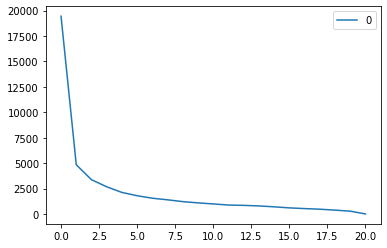

In [35]:
test.plot()

In [41]:
# Test that they load properly

df_list = []

for batch_num in range(0, 2):
    
    tensor_data = torch.load(f'../data/hetionet/protein_sequences/hetionet_protein_embeddings_{batch_num}.pt')

    df_data = pd.DataFrame.from_dict(tensor_data)


    print(len(df_data))

    df_list.append(df_data)

1000
1000


In [ ]:
data_final = pd.concat(df_list)

In [59]:
data_final.head(3)

,embedding
13,"[tensor(0.0827), tensor(-0.0253), tensor(-0.01..."
17,"[tensor(0.0327), tensor(0.0039), tensor(-0.022..."
29,"[tensor(0.0183), tensor(0.0161), tensor(0.0048..."


In [47]:
protein_batches

,From,Sequence,seq_len,embedding
11413,Q96M96,MEEIKPASASCVSKEKPSKVSDLISRFEGGSSLSNYSDLKKESAVN...,766,"[tensor(-0.0022), tensor(0.0166), tensor(-0.01..."
9112,Q9H1D0,MGPLQGDGGPALGGADVAPRLSPVRVWPRPQAPKEPALHPMGLSLP...,765,"[tensor(0.0186), tensor(0.0049), tensor(-0.008..."
2186,Q6ZSB9,MDPVATHSCHLLQQLHEQRIQGLLCDCMLVVKGVCFKAHKNVLAAF...,765,"[tensor(0.0182), tensor(0.0247), tensor(0.0040..."
9195,Q15436,MTTYLEFIQQNEERDGVRFSWNVWPSSRLEATRMVVPVAALFTPLK...,765,"[tensor(0.0362), tensor(0.0054), tensor(-0.014..."
14438,Q9NRH2,MAGFKRGYDGKIAGLYDLDKTLGRGHFAVVKLARHVFTGEKVAVKV...,765,"[tensor(-0.0100), tensor(0.0002), tensor(0.012..."
14876,Q9ULC8,MPRSPGTRLKPAKYIPVATAAALLVGSSTLFFVFTCPWLTRAVSPA...,765,"[tensor(-0.0249), tensor(-0.0225), tensor(-0.0..."
16162,Q8NFD2,MAADPTELRLGSLPVFTRDDFEGDWRLVASGGFSQVFQARHRRWRT...,765,"[tensor(0.0089), tensor(0.0230), tensor(0.0088..."
6051,Q5W0V3,MFSKFTSILQHAVEALAPSLPLQEDFVYHWKAITHYYIETSDDKAP...,765,"[tensor(0.0167), tensor(0.0277), tensor(-0.024..."
8368,Q96PH1,MNTSGDPAQTGPEGCRGTMSAEEDARWLRWVTQQFKTIAGEDGEIS...,765,"[tensor(0.0354), tensor(0.0045), tensor(-0.005..."
4661,P11387,MSGDHLHNDSQIEADFRLNDSHKHKDKHKDREHRHKEHKKEKDREK...,765,"[tensor(0.0055), tensor(0.0007), tensor(0.0028..."


In [48]:
data_final_test = pd.concat(protein_batches)

In [52]:
data_final_t = data_final_test[['From', 'embedding']]

In [54]:
data_final_t.rename(columns = {'From':'identifiers'}, inplace = True)

<ipython-input-54-5c18c138182d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final_t.rename(columns = {'From':'identifiers'}, inplace = True)


In [56]:
data_final_t = data_final_t.set_index('identifiers')

In [57]:
data_final_t

,embedding
identifiers,
Q7Z5P9,"[tensor(0.0872), tensor(-0.0217), tensor(-0.00..."
Q5VST9,"[tensor(0.0541), tensor(-0.0464), tensor(0.025..."
Q03001,"[tensor(0.1205), tensor(-0.0435), tensor(0.004..."
Q9UPN3,"[tensor(0.1249), tensor(-0.0658), tensor(0.017..."
Q8NDH2,"[tensor(0.1043), tensor(-0.0411), tensor(-0.02..."
...,...
A0A0A0MTA4,"[tensor(0.0457), tensor(-0.0048), tensor(0.016..."
A0A0A0MT89,"[tensor(0.0410), tensor(-0.0085), tensor(-0.01..."
P0DOY5,"[tensor(0.0502), tensor(-0.0196), tensor(-0.08..."


In [58]:
torch.save(data_final_t, '../data/hetionet/protein_sequences/protein_embeddings_full_hetionet.pt')

### Deal with edge cases...

In [63]:
edge_cases

,From,Sequence,seq_len,embedding
5292,Q8WZ42,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,34350,None
551,Q8WXI7,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,14507,None
13847,Q8NF91,MATSRGASRCPRDIANVMQRLQDEQEIVQKRTFTKWINSHLAKRKP...,8797,None


In [ ]:
for count, row in enumerate(edge_cases.itertuples()):        
    edge_cases.at[row.Index, 'embedding'] = torch.Tensor(get_protein_repr(row[2], prot_trans_embedder))

In [65]:
edge_cases

,From,Sequence,seq_len,embedding
5292,Q8WZ42,MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...,34350,None
551,Q8WXI7,MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...,14507,None
13847,Q8NF91,MATSRGASRCPRDIANVMQRLQDEQEIVQKRTFTKWINSHLAKRKP...,8797,None
